# Covid-19 Week to Week % Change in New Cases by Parish

This notebook will created maps for comparing weekly new cases by parish for Louisiana, as well as a timelaps video 

[Watch Latest Video](https://youtu.be/RiEHIBp87I8)

In [1]:
#change to true to regenerate video
create_new_video = False

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import Normalize
from matplotlib.colors import TwoSlopeNorm
#from matplotlib.colors import SymLogNorm  #yikes
from matplotlib.dates import DateFormatter
import geoplot as gplt
import geopandas as gpd
import geoplot.crs as gcrs

import datetime

In [3]:
df = gpd.read_file('./uscensus/cb_2018_us_county_500k.shp')
df = df[df['STATEFP']=='22']
df['FIPS'] = (df['STATEFP'].astype(int) * 1000) + df['COUNTYFP'].astype(int)
df.index = df['NAME']
df['GEOID'] = df['GEOID'].astype(int)

In [4]:
df.head(2)

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry,FIPS
NAME,,,,,,,,,,,
Acadia,22,001,00558389,0500000US22001,22001,Acadia,15,1696880710,5918557,"POLYGON ((-92.63229 30.31708, -92.62923 30.318...",22001
Avoyelles,22,009,00558424,0500000US22009,22009,Avoyelles,15,2154960192,87260913,"POLYGON ((-92.28074 30.96507, -92.21691 30.965...",22009


In [5]:
covid_df = pd.read_excel("./LaDeptHealth/LA_COVID_TESTBYDAY_PARISH_PUBLICUSE.xlsx")
covid_df['Parish'] = covid_df['Parish'].str.replace('DeSoto', 'De Soto') #De Soto fix

In [6]:
covid_df.index = covid_df['Lab Collection Date'].dt.strftime('%Y-%m-%d_') + covid_df['Parish']
covid_df.tail()

,Lab Collection Date,Parish,Daily Test Count,Daily Negative Test Count,Daily Positive Test Count,Daily Case Count
2021-03-13_Winn,2021-03-13,Winn,5,4,1,1
2021-03-14_Winn,2021-03-14,Winn,2,0,2,2
2021-03-15_Winn,2021-03-15,Winn,41,41,0,0
2021-03-16_Winn,2021-03-16,Winn,19,19,0,0
2021-03-17_Winn,2021-03-17,Winn,12,11,1,1


In [7]:
curdate = startdate = covid_df['Lab Collection Date'].min()
stopdate = covid_df['Lab Collection Date'].max()

daydelta = datetime.timedelta(days=1)
weeks = []
curweek = []
while curdate <= stopdate:
    curweek.append(curdate)
    if len(curweek) == 7:
        weeks.append(curweek)
        curweek = []
        
    curdate += daydelta
    
print(stopdate)
print(weeks[-1])

2021-03-17 00:00:00
[Timestamp('2021-03-07 00:00:00'), Timestamp('2021-03-08 00:00:00'), Timestamp('2021-03-09 00:00:00'), Timestamp('2021-03-10 00:00:00'), Timestamp('2021-03-11 00:00:00'), Timestamp('2021-03-12 00:00:00'), Timestamp('2021-03-13 00:00:00')]


In [8]:
colnames = []
la_df = pd.DataFrame(['Louisiana'], columns=['Name'],index=['Louisiana'])
for week in weeks:
    parishes = []
    totals = []
    for parish in df['NAME']:
        total = 0
        for day in week:
            try:
                total += covid_df.loc[day.strftime('%Y-%m-%d_') + parish]['Daily Case Count']
            except KeyError:
                pass
            
        totals.append(total)
        parishes.append(parish)
    
    la_total = np.sum(totals)
    
    weekname = week[0].strftime('%Y-%m-%d')
    newdataframe = pd.DataFrame(totals,index=parishes,columns=[weekname])
    newladataframe = pd.DataFrame(la_total,index=['Louisiana'],columns=[weekname])
    
    df = df.join(newdataframe,how='left')
    la_df = la_df.join(newladataframe,how='left')
    colnames.append(weekname)
    

In [9]:
df.head(2)

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry,...,2021-01-03,2021-01-10,2021-01-17,2021-01-24,2021-01-31,2021-02-07,2021-02-14,2021-02-21,2021-02-28,2021-03-07
NAME,,,,,,,,,,,,,,,,,,,,,
Acadia,22,001,00558389,0500000US22001,22001,Acadia,15,1696880710,5918557,"POLYGON ((-92.63229 30.31708, -92.62923 30.318...",...,242,131,131,105,98,72,38,44,47,36
Avoyelles,22,009,00558424,0500000US22009,22009,Avoyelles,15,2154960192,87260913,"POLYGON ((-92.28074 30.96507, -92.21691 30.965...",...,237,182,162,90,70,282,12,75,20,18


In [10]:
la_df.head()

,Name,2020-03-01,2020-03-08,2020-03-15,2020-03-22,2020-03-29,2020-04-05,2020-04-12,2020-04-19,2020-04-26,...,2021-01-03,2021-01-10,2021-01-17,2021-01-24,2021-01-31,2021-02-07,2021-02-14,2021-02-21,2021-02-28,2021-03-07
Louisiana,Louisiana,0,305,3035,7517,6769,4685,3383,2799,2592,...,24893,16911,16771,14076,9039,7054,3791,4934,3536,3186


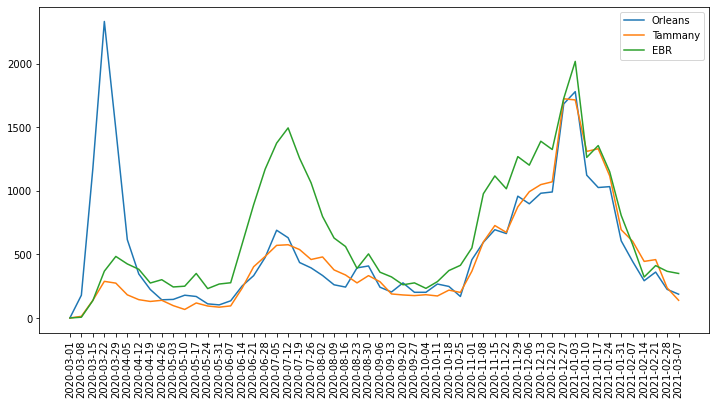

In [11]:
#sanity check
fig = plt.figure(figsize=(12,6))
plt.plot(df.loc['Orleans'][colnames], label='Orleans')
plt.plot(df.loc['St. Tammany'][colnames], label = 'Tammany')
plt.plot(df.loc['East Baton Rouge'][colnames], label = 'EBR')
_=plt.xticks(rotation=90)
plt.legend()


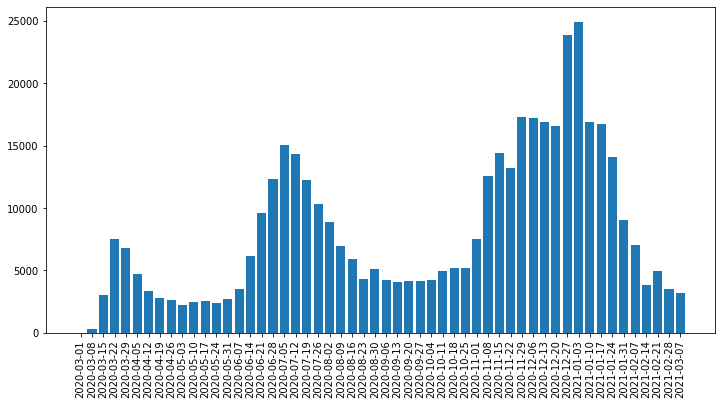

In [12]:
#sanity check
fig = plt.figure(figsize=(12,6))
plt.bar(colnames,la_df.loc['Louisiana'][colnames], label='Louisiana')
_=plt.xticks(rotation=90)

In [13]:
pop_df = pd.read_csv('./uscensus/co-est2019-alldata.csv', encoding='latin1')
pop_df = pop_df[pop_df['STATE']==22]
pop_df.index = (pop_df['STATE'] * 1000) + pop_df['COUNTY']
pop_df = pop_df[['STNAME', 'CTYNAME','POPESTIMATE2019']]
pop_df.head()

,STNAME,CTYNAME,POPESTIMATE2019
22000,Louisiana,Louisiana,4648794
22001,Louisiana,Acadia Parish,62045
22003,Louisiana,Allen Parish,25627
22005,Louisiana,Ascension Parish,126604
22007,Louisiana,Assumption Parish,21891


In [14]:
la_df['FIPS'] = [22000]
df = df.join(pop_df,how='left', on='FIPS')
la_df = la_df.join(pop_df,how='left', on='FIPS')

In [15]:
#Sanity
df.loc['Orleans']

STATEFP                        22
COUNTYFP                      071
COUNTYNS                 00558113
AFFGEOID           0500000US22071
GEOID                       22071
                        ...      
2021-02-28                    225
2021-03-07                    187
STNAME                  Louisiana
CTYNAME            Orleans Parish
POPESTIMATE2019            390144
Name: Orleans, Length: 68, dtype: object

In [16]:
df.describe()

,GEOID,ALAND,AWATER,FIPS,2020-03-01,2020-03-08,2020-03-15,2020-03-22,2020-03-29,2020-04-05,...,2021-01-10,2021-01-17,2021-01-24,2021-01-31,2021-02-07,2021-02-14,2021-02-21,2021-02-28,2021-03-07,POPESTIMATE2019
count,64.000000,6.400000e+01,6.400000e+01,64.000000,64.0,64.000000,64.000000,64.000000,64.000000,64.000000,...,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.00000,64.000000,64.000000
mean,22064.000000,1.748400e+09,3.711503e+08,22064.000000,0.0,4.765625,47.421875,117.453125,105.765625,73.203125,...,264.234375,262.046875,219.937500,141.234375,110.218750,59.234375,77.093750,55.25000,49.781250,72637.406250
std,37.237973,7.616191e+08,8.839364e+08,37.237973,0.0,23.424815,170.435093,374.079990,273.689300,148.529638,...,374.823080,366.726897,315.537228,198.813524,149.014165,97.639073,114.622045,87.22658,80.480791,98457.391656
min,22001.000000,4.388204e+08,1.209874e+06,22001.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,6.000000,10.000000,7.000000,0.000000,3.000000,0.000000,0.000000,0.00000,0.000000,4334.000000
25%,22032.500000,1.178075e+09,2.915966e+07,22032.500000,0.0,0.000000,2.000000,5.000000,10.750000,10.500000,...,62.750000,49.250000,36.500000,26.250000,26.750000,9.250000,13.750000,9.00000,6.000000,19228.000000
50%,22064.000000,1.672090e+09,6.292582e+07,22064.000000,0.0,0.000000,6.000000,19.500000,26.500000,26.000000,...,106.500000,117.000000,92.000000,67.500000,51.500000,24.500000,35.500000,22.50000,19.000000,32953.000000
75%,22095.500000,2.180215e+09,1.399125e+08,22095.500000,0.0,1.250000,21.500000,74.000000,87.750000,68.250000,...,252.250000,241.000000,195.250000,143.750000,116.500000,53.000000,73.500000,56.00000,56.250000,72903.500000
max,22127.000000,3.439291e+09,4.628006e+09,22127.000000,0.0,179.000000,1176.000000,2332.000000,1593.000000,937.000000,...,1941.000000,1838.000000,1541.000000,894.000000,686.000000,474.000000,473.000000,437.00000,438.000000,440059.000000


In [17]:
df.loc['Orleans']

STATEFP                        22
COUNTYFP                      071
COUNTYNS                 00558113
AFFGEOID           0500000US22071
GEOID                       22071
                        ...      
2021-02-28                    225
2021-03-07                    187
STNAME                  Louisiana
CTYNAME            Orleans Parish
POPESTIMATE2019            390144
Name: Orleans, Length: 68, dtype: object

In [18]:
#calculate percent changes
for lastweek, thisweek in zip(weeks[:-1],weeks[1:]):
    lastweek_col = lastweek[0].strftime('%Y-%m-%d')
    thisweek_col = thisweek[0].strftime('%Y-%m-%d')
    change_col = thisweek_col + '_chg'
    
    df[change_col] = ((df[thisweek_col] - df[lastweek_col]) / df[lastweek_col] * 100)
    la_df[change_col] = ((la_df[thisweek_col] - la_df[lastweek_col]) / la_df[lastweek_col] * 100)
        
    #print("Values for %s:\t%d" % (change_col, np.count_nonzero( df[change_col])))
df.describe()

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


,GEOID,ALAND,AWATER,FIPS,2020-03-01,2020-03-08,2020-03-15,2020-03-22,2020-03-29,2020-04-05,...,2021-01-03_chg,2021-01-10_chg,2021-01-17_chg,2021-01-24_chg,2021-01-31_chg,2021-02-07_chg,2021-02-14_chg,2021-02-21_chg,2021-02-28_chg,2021-03-07_chg
count,64.000000,6.400000e+01,6.400000e+01,64.000000,64.0,64.000000,64.000000,64.000000,64.000000,64.000000,...,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,63.000000,63.000000,63.000000
mean,22064.000000,1.748400e+09,3.711503e+08,22064.000000,0.0,4.765625,47.421875,117.453125,105.765625,73.203125,...,2.882710,-31.892304,1.113541,-18.096209,-33.056550,inf,-51.239139,inf,-29.482079,-3.460014
std,37.237973,7.616191e+08,8.839364e+08,37.237973,0.0,23.424815,170.435093,374.079990,273.689300,148.529638,...,15.228752,14.805655,27.135487,22.019949,28.905546,NaN,26.764279,NaN,31.319585,50.912497
min,22001.000000,4.388204e+08,1.209874e+06,22001.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,-33.064516,-72.463768,-58.181818,-60.000000,-100.000000,-70.588235,-100.000000,-57.142857,-76.470588,-83.333333
25%,22032.500000,1.178075e+09,2.915966e+07,22032.500000,0.0,0.000000,2.000000,5.000000,10.750000,10.500000,...,-8.268900,-39.768041,-14.146310,-29.689536,-48.790323,-36.571508,-74.632353,8.391608,-50.000000,-40.026447
50%,22064.000000,1.672090e+09,6.292582e+07,22064.000000,0.0,0.000000,6.000000,19.500000,26.500000,26.000000,...,5.742918,-33.430365,-1.734667,-18.209208,-36.187957,-21.633110,-49.519231,30.000000,-33.333333,-12.820513
75%,22095.500000,2.180215e+09,1.399125e+08,22095.500000,0.0,1.250000,21.500000,74.000000,87.750000,68.250000,...,13.125539,-24.038846,12.962230,-9.460227,-23.108747,0.000000,-30.702114,105.000000,-11.016721,14.321795
max,22127.000000,3.439291e+09,4.628006e+09,22127.000000,0.0,179.000000,1176.000000,2332.000000,1593.000000,937.000000,...,41.463415,15.662651,66.666667,81.250000,87.500000,inf,25.000000,inf,63.157895,108.695652


In [19]:
df.loc['Orleans']

STATEFP                       22
COUNTYFP                     071
COUNTYNS                00558113
AFFGEOID          0500000US22071
GEOID                      22071
                       ...      
2021-02-07_chg          -26.8534
2021-02-14_chg           -34.009
2021-02-21_chg           23.2082
2021-02-28_chg          -37.6731
2021-03-07_chg          -16.8889
Name: Orleans, Length: 121, dtype: object

In [20]:
la_series = la_df.loc['Louisiana'][colnames]

la_series.index = pd.to_datetime(la_series.index)


In [21]:
#get Louisiana water for map
#if this file is missing run ./USGS/getUSGSdata.sh
waterDf = gpd.read_file('zip://./USGS/water.zip!WATER2.SHP')

In [22]:
poplabelcutoff=50000
label_places = df[df['POPESTIMATE2019'] > poplabelcutoff]
extent=(-94.1,29,-88.6,33.05)

#generates labels
def labelgen(value):
    
    if np.isnan(value) or np.isinf(value):
        return 'NaN'
    elif value > 0.0:
        return '⇑' + str(int(value))
    else:
        return '⇓' + str(int(-value))

def getfacecolor(value):
    return '#ffffff'
    #if np.isnan(value) or np.isinf(value):
    #    return '#00BFFF'
    #elif value > 0:
    #    return '#FF0000' 
    #else:
    #    return '#00FF00'

    
def plotme(week = weeks[-1][0], startweek=weeks[-1][0], webmap = False, setnorm=False, stddev=1, savename = 'RecentMap.jpg', closefig=False, figsize=(22,15)):
    projectioncode = 'EPSG:3395'
    
    fig = plt.figure(figsize=figsize)
    spec = gridspec.GridSpec(ncols=2, nrows=1,width_ratios=[1,10])

    
    colname = week.strftime('%Y-%m-%d') + '_chg'
    validmask = np.logical_not(np.logical_or( np.isnan(df[colname]), np.isinf(df[colname]) ))
    
    normmin,normmax = (df[validmask][colname].min(), df[validmask][colname].max())
    #print("DataMin=%d\tDataMax=%d"%(normmin,normmax))
    
    if webmap:
        ax1 = fig.add_subplot(spec[1],projection=gcrs.WebMercator())
        gplt.webmap(df,ax=ax1, extent=extent)
        projectioncode = 'EPSG:3857'       
        projection = gcrs.WebMercator()
    else:
        ax1 = fig.add_subplot(spec[1],projection=gcrs.Mercator())
        projection = gcrs.Mercator()
        
    if setnorm:
        norm = setnorm
    else:
        #norm = Normalize(vmin=normmin, vmax=normmax.max())
        norm = TwoSlopeNorm(0,vmin=normmin,vmax=normmax)
    
    gplt.choropleth(df[validmask],zorder=10,hue=colname, norm=norm, legend=True, ax=ax1,extent=extent, edgecolor='black', cmap='RdYlGn_r', projection=projection)
    
    #color NaNs and inf
    gplt.polyplot( df[np.logical_not(validmask)], facecolor='#0000FF', zorder=20, ax=ax1, extent=extent, projection=projection)
    
    gplt.polyplot(waterDf,ax=ax1,extent=extent, edgecolor='#abd3df', facecolor='#abd3df', projection=projection,zorder=21)
    
    fig.suptitle("Covid-19 Week to Week %% Change in New Cases by Parish for %s" % week.strftime('%b %d, %Y').ljust(14))
    
    ax2 = fig.add_subplot(spec[0])
    ax2.set_title('Weekly New Cases for La')
    ax2.barh(la_series.index,la_series, color='y', height=6.5, label='Weekly New Cases')
    ax2.axhline(week,color='red',label='Current Week')
    
    ax2.yaxis.set_major_formatter(DateFormatter('%b %d'))
    
    for tick in ax2.get_yticklabels():
        tick.set_rotation(90)
        
        
    ax2.legend()
    
    fig.text(0.76,0.93,week.strftime('%b %d, %Y').rjust(12), \
             fontsize=18,\
             fontfamily='monospace', \
             bbox=dict(boxstyle='round',facecolor='#ffffa8',alpha=0.7))
    
    #get outliers
    mean = df[validmask][colname].mean()
    outdev = df[validmask][colname].std() * stddev
    #print("outdev=%d" %outdev)
    label_outliers = df[np.abs(df[colname] - mean) > outdev]
    
    labels = label_outliers.append(label_places).drop_duplicates()
    centroids = labels['geometry'].to_crs(projectioncode).centroid
    for x,y, name in zip(centroids.x,centroids.y, labels['NAME']):
        ax1.annotate(name.replace(' ', "\n"),xy=(x,y),xytext=(0, -6), textcoords="offset points", zorder=50, ha='center', va='top')
        
    
    centroids = df['geometry'].to_crs(projectioncode).centroid
    for x,y, value in zip(centroids.x,centroids.y, df[colname]):
        ax1.annotate(labelgen(value),xy=(x,y),xytext=(0, 6),\
                     textcoords="offset points", zorder=50,\
                     ha='center', va='center',fontsize=15,\
                     bbox=dict(boxstyle='round',facecolor=getfacecolor(value),alpha=0.4))
        
    fig.tight_layout()
    
    if savename != None:
        fig.savefig(savename)
    
    if closefig:
        plt.close()

    return norm
        


vmin=-100	vmax=100


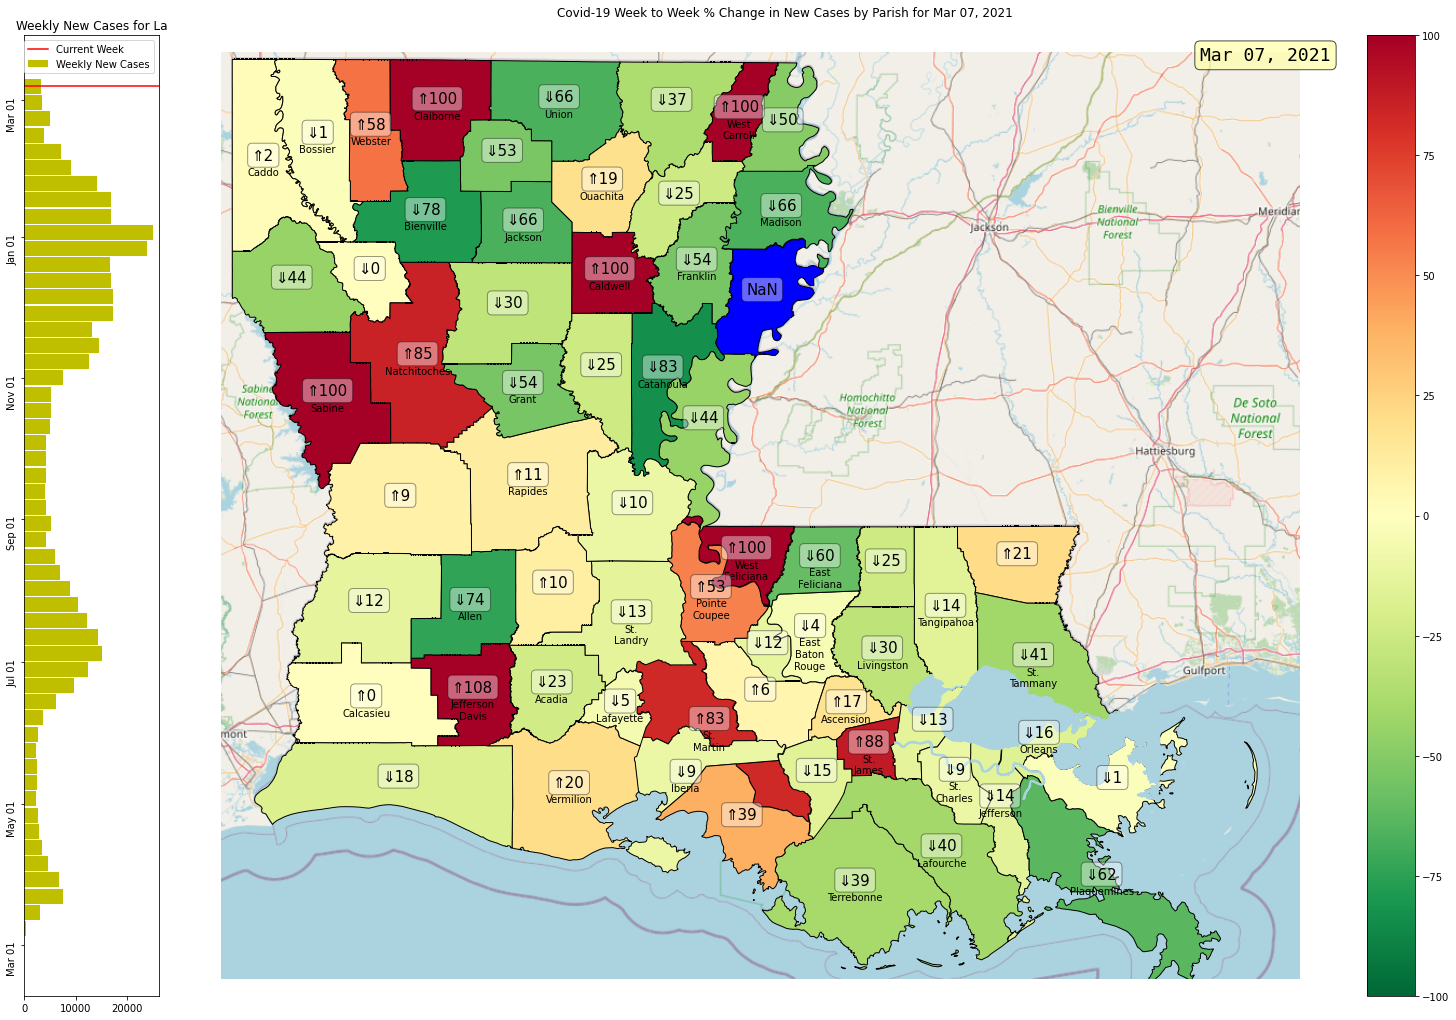

In [23]:
norm = plotme(webmap=True, week=weeks[-1][0], setnorm=Normalize(vmin=-100,vmax=100, clip=True), figsize=(22,15) ) 
print("vmin=%d\tvmax=%d" % (norm.vmin,norm.vmax))

In [24]:
#create directory for movie
if create_new_video:
    !mkdir movie2
    !rm movie2/*

In [25]:
%%time

if create_new_video:
    movienorm = Normalize(vmin=-250,vmax=250,clipped=True)

    for week in weeks[2:]:
        savename = './movie2/' + week[0].strftime("%Y-%m-%d") + '.jpg'
        plotme(week=week[0],savename=savename, webmap=False, setnorm=movienorm, closefig=True)

CPU times: user 7 µs, sys: 1e+03 ns, total: 8 µs
Wall time: 13.4 µs


In [26]:
%%time
if create_new_video:
    moviefile = "PercentChangeVideo.mp4"
    framerate = len(weeks[1:]) / 90

    !rm $moviefile
    !ffmpeg -pattern_type glob -r $framerate -f image2 -i "./movie2/*.jpg" -crf 1 $moviefile



CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 7.87 µs


In [27]:
if create_new_video:
    !vlc --fullscreen --loop ./PercentChangeVideo.mp4

In [28]:
#video title for youtube
youtube_title = "[%s] Covid-19 Week to Week %% Change in New Cases by Parish for %s" % (weeks[-1][0].strftime("%b %d"),weeks[-1][0].strftime("%b %d"))

print(youtube_title)

[Mar 07] Covid-19 Week to Week % Change in New Cases by Parish for Mar 07


In [29]:
#video description for youtube

youtube_description = """Updated:  %s
Project page:  https://github.com/GarysCorner/Covid19-LaCompared

This video shows a map of percentage changes in weekly new cases of Covid-19 for parishes in Louisiana.

The purpose of this project is to be interesting, and to show off some data processing capabilities.  This project should not be used to draw conclusion about the spread of Covid19, the effectiveness of masks, or anything really.

If you are drawing conclusion other then, "Wow, that's a neat graph", then you have made a mistake.  One should make note that there are a lot of factors that correlated to mask use/population size/infection rates, and just because two things are correlated does not mean they are causative.  For example in just this video you can see that there is a correlation between mask use and population size, a passing glance at the labels will tell us that the population densities in areas where mask use it common are probably higher.  Population density is one of those things you would expect to have influence on infection rates.  So again, if you are drawing conclusions from this video, know that you shouldn't. 


For scientific studies and things you can draw conclusions on:  https://www.cdc.gov/coronavirus/2019-ncov/index.html

""" % weeks[-1][0].strftime("%b %d, %Y")

print(youtube_description)

Updated:  Mar 07, 2021
Project page:  https://github.com/GarysCorner/Covid19-LaCompared

This video shows a map of percentage changes in weekly new cases of Covid-19 for parishes in Louisiana.

The purpose of this project is to be interesting, and to show off some data processing capabilities.  This project should not be used to draw conclusion about the spread of Covid19, the effectiveness of masks, or anything really.

If you are drawing conclusion other then, "Wow, that's a neat graph", then you have made a mistake.  One should make note that there are a lot of factors that correlated to mask use/population size/infection rates, and just because two things are correlated does not mean they are causative.  For example in just this video you can see that there is a correlation between mask use and population size, a passing glance at the labels will tell us that the population densities in areas where mask use it common are probably higher.  Population density is one of those things y

In [30]:
print(weeks[-1][0],df.loc['Avoyelles'][weeks[-1][0].strftime('%Y-%m-%d')])
print(weeks[-2][0],df.loc['Avoyelles'][weeks[-2][0].strftime('%Y-%m-%d')])

2021-03-07 00:00:00 18
2021-02-28 00:00:00 20
